# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires 32 bit python, and a 7.1!! version of vensim DSS
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [ ]:
from ema_workbench.connectors.pysd_connector import PysdModel

In [ ]:
from __future__ import (division, unicode_literals, absolute_import,
                        print_function)

from ema_workbench import (TimeSeriesOutcome, perform_experiments,
                           RealParameter, ema_logging)

from ema_workbench.connectors.vensim import VensimModel

#Import Vensim Model
model_vensim = VensimModel("PredPrey", wd=wd, model_file='\model\PredPrey.vpm')

model.uncertainties = [RealParameter("prey_birth_rate", 0, 0.5),
                             RealParameter("predation_rate", 0, 0.003)]


model.outcomes = [ScalarOutcome('TIME'),
                  TimeSeriesOutcome("predators"),
                  TimeSeriesOutcome("prey")]

# Import ExcelModel!

In [1]:
from ema_workbench.connectors.excel import ExcelModel

from ema_workbench import Model, RealParameter, ScalarOutcome, ema_logging
#Logging is important to keep track of the simulation

ema_logging.log_to_stderr(ema_logging.INFO) 

C:\Users\newbi\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


<Logger EMA (DEBUG)>

In [2]:
from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging, MultiprocessingEvaluator)

model = ExcelModel("predatorPrey", wd="./model/",
                   model_file='PredPrey.xlsx')
model.uncertainties = [RealParameter("B3", 0.1, 0.5),  # we can refer to a cell in the normal way
                       # we can also use named cells
                       RealParameter("B4", 0.0005, 0.0030),
                       RealParameter("B5", 0.001, 0.01),
                       RealParameter("B6", 0.01, 0.1),
                       RealParameter("B7", 10, 100),
                       RealParameter("B8", 10, 100)]

# specification of the outcomes
model.outcomes = [TimeSeriesOutcome("B15:BDF15"),  # we can refer to a range in the normal way
                  TimeSeriesOutcome("B16:BDF16"),
                  TimeSeriesOutcome("B17:BDF17"),
                  TimeSeriesOutcome("B18:BDF18")]  # we can also use named range - named range might be better

# name of the sheet
model.default_sheet = "Sheet1"

In [17]:
from ema_workbench import SequentialEvaluator, MultiprocessingEvaluator

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(10)

[MainProcess/INFO] performing 10 scenarios * 1 policies * 1 model(s) = 10 experiments
[MainProcess/INFO] performing experiments sequentially


EMAError: wb not open

In [10]:
for var in outcomes.keys():
    outcomes[var] = outcomes[var][:,0,:]

IndexError: too many indices for array

In [13]:
outcomes['B16:BDF16'].shape

(10, 1461)

In [19]:
import pandas as pd
#pd.DataFrame(outcomes, index = [0])
#pd.DataFrame(outcomes)
#pd.DataFrame.from_dict(outcomes, orient = "index")
pd.DataFrame([outcomes])

,B15:BDF15,B16:BDF16,B17:BDF17,B18:BDF18
0,"[[-3.4702445966924227, -3.7265091148882306, -3...","[[7.873128181618193, 7.9305984787252415, 7.977...","[[88.82201069093288, 87.95444954175979, 87.022...","[[95.09872841469782, 97.06701046010237, 99.049..."


In [6]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes.keys():
    plotting.lines(experiments, outcomes, outcomes_to_show=outcome, 
                   density=plotting_util.Density.HIST)
plt.show()

C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

EMAError: unknown density plot type

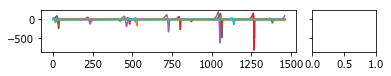

In [77]:
import matplotlib.pyplot as plt
from ema_workbench.analysis.plotting import lines

figure = lines(experiments, outcomes, density=True) #show lines, and end state density
plt.show() #show figure

lines

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results)